In [1]:
#Original Path Folder
zip_path = "/content/drive/MyDrive/Colab DataSets/Static gestures of Indian Sign Language (ISL) for English Alphabet, Hindi Vowels and Numerals.zip"

#unzipping raw data path
extract_base_path = "/content/dataset"

#organized data path
combined_dataset_path =  '/content/combined_ISL_dataset'

In [2]:
import os
import zipfile
import shutil

In [3]:
#Unzipping Dataset

print(f"Unzipping {zip_path} to {extract_base_path}...")
os.makedirs(extract_base_path, exist_ok=True) # Create extraction directory if it doesn't exist
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_base_path)
print("Unzipping complete.")

Unzipping /content/drive/MyDrive/Colab DataSets/Static gestures of Indian Sign Language (ISL) for English Alphabet, Hindi Vowels and Numerals.zip to /content/dataset...
Unzipping complete.


In [4]:
for root, dirs, files in os.walk(extract_base_path):
    for file in files:
        if file.endswith((".jpg", ".png", ".jpeg")):  # add other formats if needed
            file_path = os.path.join(root, file)

            # class name = parent folder (A, B, C, ... or 0,1,2...)
            class_name = os.path.basename(root)

            #skipping unwanted parent folder
            if class_name.lower() in ["numerals", "english alphabet"]:
                continue

            # create target directory inside processed dataset
            target_dir = os.path.join(combined_dataset_path, class_name)
            os.makedirs(target_dir, exist_ok=True)

            # move (or copy) file
            shutil.copy(file_path, os.path.join(target_dir, file))

In [5]:
#quick check
print("Classes created:", os.listdir(combined_dataset_path))
print("Example images in A:", os.listdir(os.path.join(combined_dataset_path, "A"))[:10])

Classes created: ['B', 'F', 'I', 'E2', 'U', '8', '0', 'P', '6', 'C', 'O', '4', 'X', 'N', 'M', 'L', '2', 'Q', '1', 'A', 'Z', '3', '9b', '9a', 'W', '5', 'S', 'H', 'K', '7', 'E1', 'T', 'D', 'R', 'G', 'V', 'J', 'Y']
Example images in A: ['A (105).jpg', 'A (346).jpg', 'A (467).jpg', 'A (215).jpg', 'A (566).jpg', 'A (156).jpg', 'A (21).jpg', 'A (666).jpg', 'A (690).jpg', 'A (38).jpg']


In [6]:
#quick checks 2
print("Total classes:", len(os.listdir(combined_dataset_path)))


Total classes: 38


In [7]:
for cls in os.listdir(combined_dataset_path):
    cls_path = os.path.join(combined_dataset_path, cls)
    print(cls, "->", len(os.listdir(cls_path)))


B -> 691
F -> 820
I -> 840
E2 -> 780
U -> 650
8 -> 937
0 -> 873
P -> 777
6 -> 779
C -> 579
O -> 754
4 -> 814
X -> 685
N -> 737
M -> 807
L -> 711
2 -> 910
Q -> 763
1 -> 780
A -> 721
Z -> 775
3 -> 859
9b -> 712
9a -> 899
W -> 692
5 -> 800
S -> 624
H -> 890
K -> 753
7 -> 844
E1 -> 704
T -> 699
D -> 736
R -> 744
G -> 616
V -> 720
J -> 802
Y -> 745


In [8]:
#splitting of data

import numpy as np
from sklearn.model_selection import train_test_split

#Assigning Split Paths
data_dir = combined_dataset_path
train_dir = "/content/data_split/train"
val_dir = "/content/data_split/val"
test_dir = "/content/data_split/test"

# Create split folders
for path in [train_dir, val_dir]:
    if not os.path.exists(path):
        os.makedirs(path)

# Loop through each class and split
for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    #First split: Train (80%) + Temp (20%)
    images = os.listdir(cls_path)
    train_imgs, temp_imgs = train_test_split(images, test_size=0.2, random_state=42)
    # Second split: Temp -> Validation (10%) + Test (10%)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    # Create class subfolders
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    # Copy images to respective folders
    for img in train_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(train_dir, cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(val_dir, cls, img))
    for img in test_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(test_dir, cls, img))

print("Dataset split complete!")
print("Train classes:", len(os.listdir(train_dir)))
print("Validation classes:", len(os.listdir(val_dir)))
print("Test classes:", len(os.listdir(test_dir)))

Dataset split complete!
Train classes: 38
Validation classes: 38
Test classes: 38


In [9]:
def count_images(path):
    total = 0
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            total += len(os.listdir(cls_path))
    return total

print("Image counts:")
print("Train:", count_images(train_dir))
print("Validation:", count_images(val_dir))
print("Test:", count_images(test_dir))


Image counts:
Train: 23206
Validation: 2899
Test: 2917


In [10]:
# Data Preprocessing for ISL Dataset
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import os
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import backend as K # Import K here

In [11]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 128 # Increased batch size
NUM_CLASSES = 38

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # EfficientNet prefers [-1,1]
    rotation_range=15,                 # Rotate images randomly up to 15 degrees
    width_shift_range=0.1,            # Shift images horizontally by 10%
    height_shift_range=0.1,           # Shift images vertically by 10%
    shear_range=0.15,                 # Apply shear transformations
    zoom_range=0.1,                   # Zoom in/out by 10%
    horizontal_flip=False,            # Avoid flipping horizontally (important for sign language)
    vertical_flip=False,              # Don't flip vertically
    brightness_range=[0.8, 1.2],      # Adjust brightness
    fill_mode='nearest',              # Fill pixels after transformation
    validation_split=0.0              # We already have separate validation set
)
# Validation and Test Data (only rescaling, no augmentation)
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.0
)

In [12]:
print("Creating data generators...")

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Number of classes: {train_generator.num_classes}")
print(f"Class indices: {train_generator.class_indices}")

Creating data generators...
Found 23206 images belonging to 38 classes.
Found 2899 images belonging to 38 classes.
Found 2917 images belonging to 38 classes.
Training samples: 23206
Validation samples: 2899
Test samples: 2917
Number of classes: 38
Class indices: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9a': 9, '9b': 10, 'A': 11, 'B': 12, 'C': 13, 'D': 14, 'E1': 15, 'E2': 16, 'F': 17, 'G': 18, 'H': 19, 'I': 20, 'J': 21, 'K': 22, 'L': 23, 'M': 24, 'N': 25, 'O': 26, 'P': 27, 'Q': 28, 'R': 29, 'S': 30, 'T': 31, 'U': 32, 'V': 33, 'W': 34, 'X': 35, 'Y': 36, 'Z': 37}


In [13]:
def create_tf_dataset():

    def preprocess_image(image_path, label):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

    def augment_image(image, label):
        # Data augmentation for training
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)
        image = tf.image.random_saturation(image, 0.8, 1.2)
        # Add more augmentations as needed
        image = tf.clip_by_value(image, 0.0, 1.0)
        return image, label

    # This is a template - you'd need to implement the file path collection
    # train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    # train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    # train_ds = train_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    # train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    print("tf.data approach template created")

In [14]:
# Custom preprocessing function for individual images (useful for prediction)
def preprocess_single_image(image_path, target_size=(224, 224)):
    """
    Preprocess a single image for prediction
    """
    try:
        # Load and preprocess image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, target_size)
        image = image.astype('float32') / 255.0
        image = np.expand_dims(image, axis=0)  # Add batch dimension
        return image
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

In [15]:
# Advanced preprocessing options
def apply_advanced_preprocessing():
    """
    Additional preprocessing techniques you might want to consider
    """
    advanced_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=25,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        zoom_range=0.15,
        brightness_range=[0.7, 1.3],
        channel_shift_range=0.1,
        fill_mode='nearest',
        # Add noise
        preprocessing_function=lambda x: x + tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=0.01)
    )
    return advanced_datagen

In [16]:
# Performance optimization
def optimize_dataset_performance(dataset):
    """
    Optimize dataset for training performance
    """
    AUTOTUNE = tf.data.AUTOTUNE
    dataset = dataset.cache()  # Cache the dataset in memory
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset


In [17]:
# Check class distribution
def analyze_class_distribution():
    """
    Analyze the distribution of classes in your dataset
    """
    class_counts = {}

    for split_name, split_dir in [('Train', train_dir), ('Val', val_dir), ('Test', test_dir)]:
        print(f"\n{split_name} Set Distribution:")
        split_counts = {}
        for cls in os.listdir(split_dir):
            cls_path = os.path.join(split_dir, cls)
            if os.path.isdir(cls_path):
                count = len(os.listdir(cls_path))
                split_counts[cls] = count
                if cls not in class_counts:
                    class_counts[cls] = {}
                class_counts[cls][split_name] = count
        # Sort by count
        sorted_classes = sorted(split_counts.items(), key=lambda x: x[1], reverse=True)
        for cls, count in sorted_classes:
            print(f"  {cls}: {count}")

    return class_counts

In [18]:
# Run class distribution analysis
print("\nAnalyzing class distribution...")
class_distribution = analyze_class_distribution()


Analyzing class distribution...

Train Set Distribution:
  8: 749
  2: 728
  9a: 719
  H: 712
  0: 698
  3: 687
  7: 675
  I: 672
  F: 656
  4: 651
  M: 645
  J: 641
  5: 640
  E2: 624
  1: 624
  6: 623
  P: 621
  Z: 620
  Q: 610
  O: 603
  K: 602
  Y: 596
  R: 595
  N: 589
  D: 588
  A: 576
  V: 576
  9b: 569
  L: 568
  E1: 563
  T: 559
  W: 553
  B: 552
  X: 548
  U: 520
  S: 499
  G: 492
  C: 463

Val Set Distribution:
  8: 94
  2: 91
  9a: 90
  H: 89
  0: 87
  3: 86
  I: 84
  7: 84
  F: 82
  4: 81
  M: 81
  5: 80
  J: 80
  E2: 78
  P: 78
  6: 78
  1: 78
  Z: 77
  Q: 76
  O: 75
  K: 75
  N: 74
  D: 74
  R: 74
  Y: 74
  A: 72
  V: 72
  L: 71
  9b: 71
  E1: 70
  T: 70
  B: 69
  W: 69
  X: 68
  U: 65
  S: 62
  G: 62
  C: 58

Test Set Distribution:
  8: 94
  2: 91
  9a: 90
  H: 89
  0: 88
  3: 86
  7: 85
  I: 84
  F: 82
  4: 82
  M: 81
  J: 81
  5: 80
  E2: 78
  P: 78
  6: 78
  1: 78
  Z: 78
  Q: 77
  O: 76
  K: 76
  R: 75
  Y: 75
  N: 74
  D: 74
  A: 73
  L: 72
  9b: 72
  V: 72
  E1: 

In [19]:
# Calculate dataset statistics
def calculate_dataset_stats():
    """
    Calculate mean and std of the dataset for normalization
    """
    print("\nCalculating dataset statistics...")

    # Sample a few batches to estimate statistics
    mean_sum = np.zeros(3)
    std_sum = np.zeros(3)
    total_samples = 0

    for i, (batch_images, _) in enumerate(train_generator):
        if i >= 10:  # Sample first 10 batches
            break

        batch_mean = np.mean(batch_images, axis=(0, 1, 2))
        batch_std = np.std(batch_images, axis=(0, 1, 2))

        mean_sum += batch_mean * batch_images.shape[0]
        std_sum += batch_std * batch_images.shape[0]
        total_samples += batch_images.shape[0]

    dataset_mean = mean_sum / total_samples
    dataset_std = std_sum / total_samples

    print(f"Dataset Mean (RGB): {dataset_mean}")
    print(f"Dataset Std (RGB): {dataset_std}")

    return dataset_mean, dataset_std

In [20]:

# Calculate stats
dataset_mean, dataset_std = calculate_dataset_stats()


Calculating dataset statistics...
Dataset Mean (RGB): [163.38269806 148.6513916  139.83261108]
Dataset Std (RGB): [49.65274963 49.92705612 50.75171204]


In [21]:
def calculate_class_weights_for_generators(train_generator):
    """
    Calculate class weights from your existing train_generator
    """
    # Get class distribution from generator
    class_indices = train_generator.class_indices

    # Count from your existing class distribution data
    distribution = {
        'C': 463, 'G': 492, 'S': 499, 'U': 520, 'X': 548, 'B': 552, 'W': 553,
        'T': 559, 'E1': 563, 'L': 568, '9b': 569, 'A': 576, 'V': 576, 'D': 588,
        'N': 589, 'R': 595, 'Y': 596, 'K': 602, 'O': 603, 'P': 621, 'Z': 620,
        'Q': 610, '6': 623, '1': 624, 'E2': 624, '5': 640, 'J': 641, 'M': 645,
        '4': 651, 'F': 656, 'I': 672, '7': 675, '3': 687, '0': 698, 'H': 712,
        '9a': 719, '2': 728, '8': 749
    }

    # Map to class indices and calculate weights
    class_weights = {}
    total_samples = sum(distribution.values())

    for class_name, count in distribution.items():
        if class_name in class_indices:
            class_idx = class_indices[class_name]
            class_weights[class_idx] = total_samples / (len(distribution) * count)

    print("Class weights calculated for handling imbalance")
    print(f"Total samples: {total_samples}")
    print(f"Number of classes: {len(distribution)}")
    print(f"Weight range: {min(class_weights.values()):.3f} - {max(class_weights.values()):.3f}")

    return class_weights


In [22]:
# --- CBAM Helper Functions ---
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Activation, Lambda, concatenate, Conv2D, multiply
from tensorflow.keras import backend as K

def channel_attention(input_feature, ratio=8):
    """
    Channel Attention Module
    """
    channel_axis = -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = Dense(channel // ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = tf.keras.layers.add([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    # Element-wise multiplication
    return multiply([input_feature, cbam_feature])

In [23]:
def spatial_attention_with_output_shape(input_feature, kernel_size=7):
    """
    Spatial Attention Module with explicit output_shape for Lambda layers
    """
    import tensorflow as tf # Ensure tf is imported
    # from tensorflow.keras import backend as K # Remove import of K alias
    channel_axis = -1
    # Use tf.keras.backend directly instead of K
    input_shape = tf.keras.backend.int_shape(input_feature)

    # Use tf.keras.backend directly instead of K
    avg_pool = Lambda(lambda x: tf.keras.backend.mean(x, axis=channel_axis, keepdims=True), output_shape=(input_shape[1], input_shape[2], 1))(input_feature)
    max_pool = Lambda(lambda x: tf.keras.backend.max(x, axis=channel_axis, keepdims=True), output_shape=(input_shape[1], input_shape[2], 1))(input_feature)
    concat = concatenate([avg_pool, max_pool], axis=channel_axis)

    cbam_feature = Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)

    # Element-wise multiplication
    return multiply([input_feature, cbam_feature])

In [24]:
def cbam_block(cbam_input, ratio=8, kernel_size=7):
    """
    Combined CBAM Block
    """
    channel_refined_feature = channel_attention(cbam_input, ratio)
    spatial_refined_feature = spatial_attention_with_output_shape(channel_refined_feature, kernel_size)
    return spatial_refined_feature

In [25]:
# --- Modified Model Building Function ---
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Reshape, MultiHeadAttention, LayerNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications.efficientnet import preprocess_input
# from tensorflow.keras import backend as K # Remove redundant import

# Import CBAM helper functions (assuming they are defined in other cells and accessible)
# from .cbam_helpers import cbam_block # If they were in a separate file
# Since they are in other cells in this notebook, they are likely accessible directly
# We just need to make sure the functions (cbam_block, channel_attention, spatial_attention)
# are defined before this cell is executed.

def build_efficientnet_model(fine_tune=True, IMG_HEIGHT=224, IMG_WIDTH=224, unfreeze_layers=50, num_mha_heads=4, mha_key_dim=64):
    """
    Build EfficientNet-B0 -> CBAM -> GAP -> Transformer -> Dense model
    """
    print("Building EfficientNet-B0 + CBAM + Transformer model for ISL recognition...")
    # NUM_CLASSES is defined globally, no need to redefine here

    # Load pre-trained EfficientNet-B0
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )

    # --- Fine-tuning logic (preserved from original) ---
    if not fine_tune:
         # Freeze all layers if not fine-tuning
        base_model.trainable = False
    else:
        # Mark entire backbone trainable first (we will freeze the earlier part explicitly)
        base_model.trainable = True

        # Compute cutoff index (freeze layers BEFORE this index)
        cutoff = max(0, len(base_model.layers) - int(unfreeze_layers))

        # Freeze all layers up to cutoff (this includes BatchNorm)
        print(f"Fine-tuning: Freezing first {cutoff} layers of base model.")
        for layer in base_model.layers[:cutoff]:
            layer.trainable = False

        # For the tail (last `unfreeze_layers`), keep them trainable EXCEPT keep any BatchNorm non-trainable
        print(f"Fine-tuning: Keeping last {len(base_model.layers) - cutoff} layers trainable (except BN).")
        for layer in base_model.layers[cutoff:]:
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = False   # Keep BN frozen (safer for small batch sizes)
            else:
                layer.trainable = True
    # --- End Fine-tuning logic ---

    # Get the output tensor of the base model
    x = base_model.output

    # --- Add CBAM Block ---
    print("Adding CBAM block...")
    x = cbam_block(x) # Apply CBAM before GAP

    # --- Global Average Pooling ---
    x = GlobalAveragePooling2D(name='global_avg_pooling')(x)
    # Note: Removed BatchNormalization(name='bn_features') as requested

    # --- Transformer Style Block (MHA + LayerNorm) ---
    print("Adding Transformer block (MHA + LayerNorm)...")
    # Store GAP output shape for reshaping and residual connection
    gap_output_shape = K.int_shape(x)[-1] # Get the number of features

    # 1. Reshape for MultiHeadAttention: (batch, sequence_length, features)
    # Treat the GAP output as a sequence of length 1
    x_seq = Reshape((1, gap_output_shape), name='reshape_for_mha')(x)

    # 2. MultiHeadAttention
    # Using the reshaped output as query, key, and value
    mha_output = MultiHeadAttention(
        num_heads=num_mha_heads, key_dim=mha_key_dim, name='multi_head_attention'
    )(query=x_seq, value=x_seq, key=x_seq)

    # 3. Layer Normalization (applied after attention)
    mha_output_norm = LayerNormalization(epsilon=1e-6, name='mha_layer_norm')(mha_output)

    # 4. Residual Connection (Add input to MHA block)
    # Add the output of LayerNorm to the *original input* of the MHA block (x_seq)
    transformer_output = tf.keras.layers.add([x_seq, mha_output_norm], name='transformer_residual_add')

    # 5. Flatten to remove the sequence dimension (length 1)
    x = Flatten(name='flatten_transformer_output')(transformer_output)
    # --- End Transformer Block ---

    # --- Dense Layers (Reduced) ---
    # Removed the first Dropout(0.4) and the BN after Dense(512)
    print("Adding reduced Dense layers...")
    x = Dropout(0.3, name='dropout_dense_1')(x) # Adjusted dropout rate if needed
    x = Dense(256, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(1e-4), name='dense_256')(x)
    # Note: Removed BatchNormalization(name='bn_512') and Dropout(0.3, name='dropout_512')
    x = Dropout(0.2, name='dropout_dense_2')(x) # Optional additional dropout

    # --- Output Layer ---
    predictions = Dense(
        NUM_CLASSES,
        activation='softmax',
        name='predictions',
        kernel_regularizer=tf.keras.regularizers.l2(1e-4) # Kept regularization
    )(x)

    # --- Create Model ---
    model = Model(inputs=base_model.input, outputs=predictions, name='EfficientNetB0_CBAM_Transformer_ISL')

    print(f"\nModel Summary:")
    trainable_count = sum([1 for layer in model.layers if layer.trainable])
    non_trainable_count = len(model.layers) - trainable_count
    print(f"Total layers: {len(model.layers)}")
    print(f"Trainable layers: {trainable_count}")
    print(f"Non-trainable layers: {non_trainable_count}")


    # Optional: Print trainable status summary for base model layers after modification
    # print("\nBase Model Layer Trainable Status after setup:")
    # for i, layer in enumerate(base_model.layers):
    #     print(f"{i}: {layer.name} - Trainable: {layer.trainable}")


    return model

In [26]:
def compile_efficientnet_model(model, learning_rate=1e-4):
    """
    Compile the model with optimized settings
    """
    optimizer = AdamW(
        learning_rate=learning_rate,
        weight_decay=1e-5
    )

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'),
            tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy')
        ]
    )

    print(f"Model compiled with learning rate: {learning_rate}")
    return model


In [27]:
# === CELL 3 (Callbacks) ===
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import os
import json

class EpochWeightsCheckpoint(tf.keras.callbacks.Callback):
    """
    Save model weights (NOT full model) every `interval` epochs.
    This avoids model architecture serialization issues caused by Lambda/custom objects.
    """
    def __init__(self, save_path_template, interval=5):
        super().__init__()
        self.save_path_template = save_path_template
        self.interval = int(interval)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            path = self.save_path_template.format(epoch=epoch+1)
            # Save only weights
            self.model.save_weights(path)
            print(f"\n✅ Saved weights checkpoint: {path}")

def create_training_callbacks(model_name, stage, weights_interval=5):
    checkpoint_dir = f"/content/drive/MyDrive/model_checkpoints/{model_name}_{stage}"
    os.makedirs(checkpoint_dir, exist_ok=True)

    callbacks = [
        # Save best weights (only)
        ModelCheckpoint(
            filepath=f'{checkpoint_dir}/best.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            mode='max',
            verbose=1
        ),
        # Custom periodic weight saving
        EpochWeightsCheckpoint(
            save_path_template=f'{checkpoint_dir}/epoch{{epoch:02d}}.weights.h5',
            interval=weights_interval
        ),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
    ]

    return callbacks


In [28]:
# === CELL 4 (Training routine - optimized for GPU) ===
import tensorflow as tf
import os
from tensorflow.keras import backend as K

# === Enable GPU optimizations ===
# Dynamic memory growth (avoids preallocating full GPU memory)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ Enabled dynamic memory growth for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(e)

# Enable XLA (Accelerated Linear Algebra) for faster GPU kernels
tf.config.optimizer.set_jit(True)
print("✅ XLA compilation enabled (may speed up model training)")

def train_efficientnet_two_stages(model, train_generator, validation_generator, class_weights,
                                  stage1_epochs=10, stage2_epochs=15,
                                  model_name="EfficientNet", unfreeze_layers=None):
    """
    Two-stage training:
      - Stage 1: train the custom head (keep backbone frozen except specified layers)
      - Stage 2: unfreeze backbone tail (or all) and fine-tune
    """

    print("="*60)
    print("STAGE 1: Training the custom classification head")
    print("="*60)

    # Layers we want trainable in Stage 1
    layers_to_train_stage1 = [
        'global_avg_pooling', 'reshape_for_mha', 'multi_head_attention', 'mha_layer_norm',
        'transformer_residual_add', 'flatten_transformer_output', 'dropout_dense_1',
        'dense_256', 'dropout_dense_2', 'predictions'
    ]

    # Freeze all layers except the classification head
    for layer in model.layers:
        if layer.name in layers_to_train_stage1:
            layer.trainable = True
        else:
            layer.trainable = False
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = False

    # Compile model for Stage 1
    model = compile_efficientnet_model(model, learning_rate=0.001)
    callbacks_stage1 = create_training_callbacks(model_name=model_name, stage="Stage1", weights_interval=5)

    # Prefetch data from generator (GPU efficiency)
    train_dataset = train_generator
    val_dataset = validation_generator

    history_stage1 = model.fit(
        train_dataset,
        epochs=stage1_epochs,
        validation_data=val_dataset,
        class_weight=class_weights,
        callbacks=callbacks_stage1,
        verbose=1
    )

    print("="*60)
    print("STAGE 2: Fine-tuning the model")
    print("="*60)

    # Unfreeze all layers (except BatchNorm)
    for layer in model.layers:
        layer.trainable = True
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

    # Recompile with a lower learning rate for fine-tuning
    model = compile_efficientnet_model(model, learning_rate=0.0001)
    callbacks_stage2 = create_training_callbacks(model_name=model_name, stage="Stage2", weights_interval=5)

    history_stage2 = model.fit(
        train_dataset,
        epochs=stage2_epochs,
        validation_data=val_dataset,
        class_weight=class_weights,
        callbacks=callbacks_stage2,
        verbose=1
    )
    # At the END: save final weights and model architecture (JSON)
    final_dir = f'/content/drive/MyDrive/model_checkpoints/{model_name}_Stage2'
    os.makedirs(final_dir, exist_ok=True)

    # ✅ Keras requires ".weights.h5" (not "_weights.h5")
    final_weights_path = os.path.join(final_dir, 'final.weights.h5')
    model.save_weights(final_weights_path)
    print(f"✅ Final weights saved to: {final_weights_path}")

    # Save model architecture (json)
    arch_path = os.path.join(final_dir, 'model_architecture.json')
    with open(arch_path, 'w') as f:
        f.write(model.to_json())
    print(f"✅ Model architecture JSON saved to: {arch_path}")

    return model, history_stage1, history_stage2


✅ Enabled dynamic memory growth for 1 GPU(s)
✅ XLA compilation enabled (may speed up model training)


In [29]:
def evaluate_model_performance(model, test_generator):
    """
    Evaluate model performance using your test_generator
    """
    print("Evaluating model performance...")

    # Evaluate on test set
    test_results = model.evaluate(test_generator, verbose=1)

    print(f"\nTest Results:")
    print(f"Test Loss: {test_results[0]:.4f}")
    print(f"Test Accuracy: {test_results[1]:.4f} ({test_results[1]*100:.2f}%)")
    print(f"Top-3 Accuracy: {test_results[2]:.4f} ({test_results[2]*100:.2f}%)")
    print(f"Top-5 Accuracy: {test_results[3]:.4f} ({test_results[3]*100:.2f}%)")

    return test_results

def plot_training_history(history_stage1, history_stage2):
    """
    Plot training history for both stages
    """
    import matplotlib.pyplot as plt

    # Combine histories
    epochs_stage1 = range(1, len(history_stage1.history['accuracy']) + 1)
    epochs_stage2 = range(len(epochs_stage1) + 1, len(epochs_stage1) + len(history_stage2.history['accuracy']) + 1)

    plt.figure(figsize=(15, 5))

    # Plot accuracy
    plt.subplot(1, 3, 1)
    plt.plot(epochs_stage1, history_stage1.history['accuracy'], 'bo-', label='Stage 1 Train')
    plt.plot(epochs_stage1, history_stage1.history['val_accuracy'], 'ro-', label='Stage 1 Val')
    plt.plot(epochs_stage2, history_stage2.history['accuracy'], 'b.-', label='Stage 2 Train')
    plt.plot(epochs_stage2, history_stage2.history['val_accuracy'], 'r.-', label='Stage 2 Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs_stage1, history_stage1.history['loss'], 'bo-', label='Stage 1 Train')
    plt.plot(epochs_stage1, history_stage1.history['val_loss'], 'ro-', label='Stage 1 Val')
    plt.plot(epochs_stage2, history_stage2.history['loss'], 'b.-', label='Stage 2 Train')
    plt.plot(epochs_stage2, history_stage2.history['val_loss'], 'r.-', label='Stage 2 Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot top-3 accuracy
    plt.subplot(1, 3, 3)
    plt.plot(epochs_stage1, history_stage1.history['top_3_accuracy'], 'go-', label='Stage 1 Train')
    plt.plot(epochs_stage1, history_stage1.history['val_top_3_accuracy'], 'mo-', label='Stage 1 Val')
    plt.plot(epochs_stage2, history_stage2.history['top_3_accuracy'], 'g.-', label='Stage 2 Train')
    plt.plot(epochs_stage2, history_stage2.history['val_top_3_accuracy'], 'm.-', label='Stage 2 Val')
    plt.title('Top-3 Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Top-3 Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Build and prepare the model
print("="*80)
print("BUILDING EFFICIENTNET-B0 MODEL FOR ISL RECOGNITION")
print("="*80)

# Calculate class weights using your existing data
class_weights = calculate_class_weights_for_generators(train_generator)

# Build the model
efficientnet_model = build_efficientnet_model(True, IMG_WIDTH = 224, IMG_HEIGHT = 224 ,unfreeze_layers= 50)

# Display model summary
efficientnet_model.summary()

print("\n" + "="*80)
print("MODEL READY FOR TRAINING!")
print("="*80)
print("To start training, run:")
print("trained_model, history1, history2 = train_efficientnet_two_stages(")
print("    efficientnet_model, train_generator, validation_generator, class_weights)")
print("\nTo evaluate after training:")
print("test_results = evaluate_model_performance(trained_model, test_generator)")
print("="*80)

BUILDING EFFICIENTNET-B0 MODEL FOR ISL RECOGNITION
Class weights calculated for handling imbalance
Total samples: 23206
Number of classes: 38
Weight range: 0.815 - 1.319
Building EfficientNet-B0 + CBAM + Transformer model for ISL recognition...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Fine-tuning: Freezing first 188 layers of base model.
Fine-tuning: Keeping last 50 layers trainable (except BN).
Adding CBAM block...
Adding Transformer block (MHA + LayerNorm)...
Adding reduced Dense layers...

Model Summary:
Total layers: 262
Trainable layers: 63
Non-trainable layers: 199


Model: "EfficientNetB0_CBAM_Transformer_ISL"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 6,113,739 (23.32 MB)

 Trainable params: 4,572,856 (17.44 MB)

 Non-trainable params: 1,540,883 (5.88 MB)


MODEL READY FOR TRAINING!
To start training, run:
trained_model, history1, history2 = train_efficientnet_two_stages(
    efficientnet_model, train_generator, validation_generator, class_weights)

To evaluate after training:
test_results = evaluate_model_performance(trained_model, test_generator)


In [30]:
# 1. Calculate class weights and build model (already done)
class_weights = calculate_class_weights_for_generators(train_generator) # Keep using generator for class indices for now
efficientnet_model = build_efficientnet_model(True, IMG_HEIGHT =224 , IMG_WIDTH=224, unfreeze_layers=50)

# print trainable summary
trainable_list = [(i, layer.name, layer.trainable) for i, layer in enumerate(efficientnet_model.layers)]
for idx, name, tr in trainable_list:
    print(idx, name, "trainable=" , tr)

trainable_params = int(np.sum([K.count_params(w) for w in efficientnet_model.trainable_weights]))
non_trainable_params = int(np.sum([K.count_params(w) for w in efficientnet_model.non_trainable_weights]))
print("Trainable params:", f"{trainable_params:,}")
print("Non-trainable params:", f"{non_trainable_params:,}")
print("Total params:", f"{trainable_params + non_trainable_params:,}")

# 2. Start training
trained_model, history1, history2 = train_efficientnet_two_stages(
    efficientnet_model,
    train_generator,  # Use the existing train_generator
    validation_generator, # Use the existing validation_generator
    class_weights
)

Class weights calculated for handling imbalance
Total samples: 23206
Number of classes: 38
Weight range: 0.815 - 1.319
Building EfficientNet-B0 + CBAM + Transformer model for ISL recognition...
Fine-tuning: Freezing first 188 layers of base model.
Fine-tuning: Keeping last 50 layers trainable (except BN).
Adding CBAM block...
Adding Transformer block (MHA + LayerNorm)...
Adding reduced Dense layers...

Model Summary:
Total layers: 262
Trainable layers: 63
Non-trainable layers: 199
0 input_layer_1 trainable= False
1 rescaling_2 trainable= False
2 normalization_1 trainable= False
3 rescaling_3 trainable= False
4 stem_conv_pad trainable= False
5 stem_conv trainable= False
6 stem_bn trainable= False
7 stem_activation trainable= False
8 block1a_dwconv trainable= False
9 block1a_bn trainable= False
10 block1a_activation trainable= False
11 block1a_se_squeeze trainable= False
12 block1a_se_reshape trainable= False
13 block1a_se_reduce trainable= False
14 block1a_se_expand trainable= False
15 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0311 - loss: 3.7546 - top_3_accuracy: 0.0975 - top_5_accuracy: 0.1627
Epoch 1: val_accuracy improved from -inf to 0.07416, saving model to /content/drive/MyDrive/model_checkpoints/EfficientNet_Stage1/best.weights.h5
182/182 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.0312 - loss: 3.7535 - top_3_accuracy: 0.0977 - top_5_accuracy: 0.1630 - val_accuracy: 0.0742 - val_loss: 3.0197 - val_top_3_accuracy: 0.2256 - val_top_5_accuracy: 0.3598 - learning_rate: 0.0010
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1034 - loss: 2.9705 - top_3_accuracy: 0.2722 - top_5_accuracy: 0.4215
Epoch 2: val_accuracy improved from 0.07416 to 0.24560, saving model to /content/drive/MyDrive/model_checkpoints/EfficientNet_Stage1/best.weights.h5
182/182 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.1035 - loss: 2.9695 - top_3_accuracy: 0.2725 - top_5_accuracy: 0.4219 - val_accuracy: 0.2456 - val_loss: 2.3601 - val_top_3_accur

In [31]:
print(train_generator.image_data_generator)
print(validation_generator.image_data_generator)
print(test_generator.image_data_generator)


In [32]:
print(train_generator.class_indices)
print(test_generator.class_indices)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9a': 9, '9b': 10, 'A': 11, 'B': 12, 'C': 13, 'D': 14, 'E1': 15, 'E2': 16, 'F': 17, 'G': 18, 'H': 19, 'I': 20, 'J': 21, 'K': 22, 'L': 23, 'M': 24, 'N': 25, 'O': 26, 'P': 27, 'Q': 28, 'R': 29, 'S': 30, 'T': 31, 'U': 32, 'V': 33, 'W': 34, 'X': 35, 'Y': 36, 'Z': 37}
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9a': 9, '9b': 10, 'A': 11, 'B': 12, 'C': 13, 'D': 14, 'E1': 15, 'E2': 16, 'F': 17, 'G': 18, 'H': 19, 'I': 20, 'J': 21, 'K': 22, 'L': 23, 'M': 24, 'N': 25, 'O': 26, 'P': 27, 'Q': 28, 'R': 29, 'S': 30, 'T': 31, 'U': 32, 'V': 33, 'W': 34, 'X': 35, 'Y': 36, 'Z': 37}


In [33]:
def describe_generator(gen, name):
    cfg = gen.image_data_generator.__dict__
    print(f"\n{name} configuration:")
    print(f"  Rescale: {cfg.get('rescale')}")
    print(f"  Preprocessing function: {cfg.get('preprocessing_function')}")
    print(f"  Rotation range: {cfg.get('rotation_range')}")
    print(f"  Width shift: {cfg.get('width_shift_range')}")
    print(f"  Height shift: {cfg.get('height_shift_range')}")
    print(f"  Horizontal flip: {cfg.get('horizontal_flip')}")
    print(f"  Zoom range: {cfg.get('zoom_range')}")
    print(f"  Validation split: {cfg.get('validation_split')}")

describe_generator(train_generator, "Train Generator")
describe_generator(validation_generator, "Validation Generator")
describe_generator(test_generator, "Test Generator")



Train Generator configuration:
  Rescale: None
  Preprocessing function: <function preprocess_input at 0x7d211276e340>
  Rotation range: 15
  Width shift: 0.1
  Height shift: 0.1
  Horizontal flip: False
  Zoom range: [0.9, 1.1]
  Validation split: None

Validation Generator configuration:
  Rescale: None
  Preprocessing function: <function preprocess_input at 0x7d211276e340>
  Rotation range: 0
  Width shift: 0.0
  Height shift: 0.0
  Horizontal flip: False
  Zoom range: [1.0, 1.0]
  Validation split: None

Test Generator configuration:
  Rescale: None
  Preprocessing function: <function preprocess_input at 0x7d211276e340>
  Rotation range: 0
  Width shift: 0.0
  Height shift: 0.0
  Horizontal flip: False
  Zoom range: [1.0, 1.0]
  Validation split: None


In [35]:
# 1️⃣ Verify model structure and outputs
trained_model.summary()
print("Output layer:", trained_model.layers[-1].name)
print("Activation:", trained_model.layers[-1].activation)

# 2️⃣ Evaluate validation data using SAME model (not just test)
val_results = trained_model.evaluate(validation_generator, verbose=1)
print(f"\nValidation (from reloaded model): {val_results[1]*100:.2f}% accuracy")

# 3️⃣ Evaluate test data using SAME model and compare accuracies
# Define test_results within this cell
test_results = evaluate_model_performance(trained_model, test_generator) # Calculate test_results

print(f"Test Accuracy: {test_results[1]*100:.2f}%") # Now test_results is defined and can be used

Model: "EfficientNetB0_CBAM_Transformer_ISL"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 18,173,141 (69.33 MB)

 Trainable params: 6,029,700 (23.00 MB)

 Non-trainable params: 84,039 (328.28 KB)

 Optimizer params: 12,059,402 (46.00 MB)

Output layer: predictions
Activation: <function softmax at 0x7d211dec2de0>
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 454ms/step - accuracy: 0.9887 - loss: 0.0734 - top_3_accuracy: 0.9994 - top_5_accuracy: 1.0000

Validation (from reloaded model): 99.38% accuracy
Evaluating model performance...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9907 - loss: 0.0763 - top_3_accuracy: 1.0000 - top_5_accuracy: 1.0000

Test Results:
Test Loss: 0.0589
Test Accuracy: 0.9949 (99.49%)
Top-3 Accuracy: 1.0000 (100.00%)
Top-5 Accuracy: 1.0000 (100.00%)
Test Accuracy: 99.49%


Loading model architecture and weights...
✅ Model rebuilt, weights loaded, and compiled successfully — ready for evaluation!



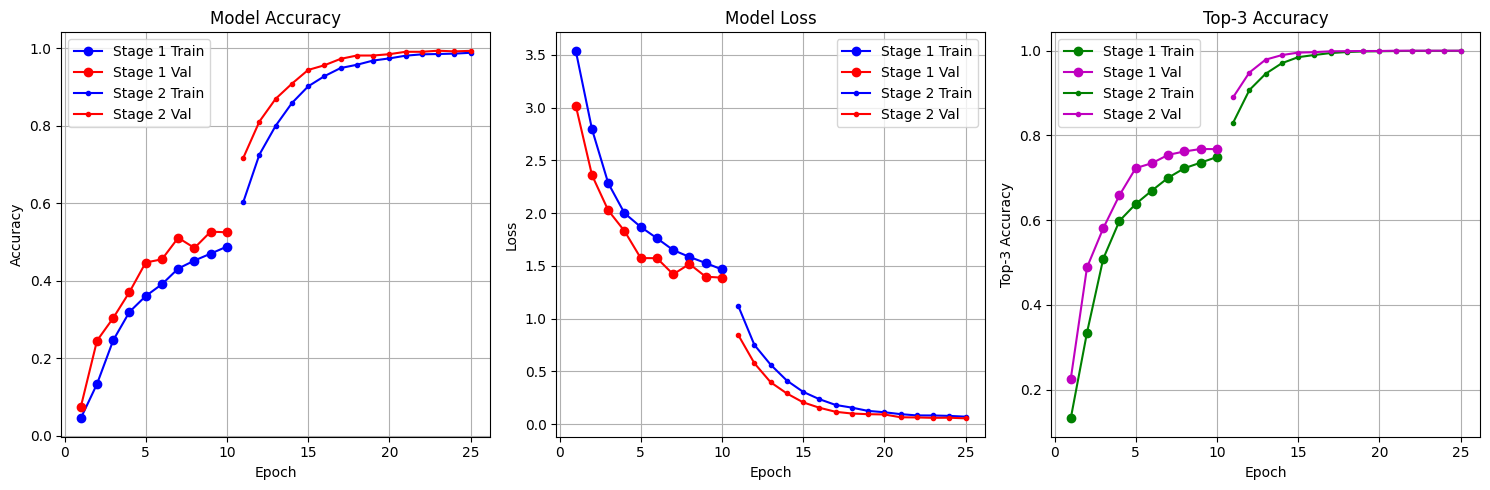

In [44]:
# === EVALUATION CELL (Updated for weights-based model loading) ===
import tensorflow as tf
from tensorflow.keras import backend as K
import builtins
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Activation, Lambda, concatenate, Conv2D, multiply # Import necessary layers

# ✅ Make K global for Lambda deserialization
builtins.K = K

# --- Redefine CBAM attention (same as before, needed for custom_objects) ---
def channel_attention(input_feature, ratio=8):
    """
    Channel Attention Module
    """
    channel_axis = -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = Dense(channel // ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = tf.keras.layers.add([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    # Element-wise multiplication
    return multiply([input_feature, cbam_feature])

# --- Named functions for Lambda layers ---
def keras_mean_function(x):
    return tf.keras.backend.mean(x, axis=-1, keepdims=True)

def keras_max_function(x):
    return tf.keras.backend.max(x, axis=-1, keepdims=True)


def spatial_attention_with_output_shape(input_feature, kernel_size=7):
    """
    Spatial Attention Module using named functions for Lambda layers
    """
    channel_axis = -1
    input_shape = tf.keras.backend.int_shape(input_feature)

    # Use named functions instead of lambdas
    avg_pool = Lambda(keras_mean_function, output_shape=(input_shape[1], input_shape[2], 1))(input_feature)
    max_pool = Lambda(keras_max_function, output_shape=(input_shape[1], input_shape[2], 1))(input_feature)
    concat = concatenate([avg_pool, max_pool], axis=channel_axis)

    cbam_feature = Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)

    # Element-wise multiplication
    return multiply([input_feature, cbam_feature])

def cbam_block(cbam_input, ratio=8, kernel_size=7):
    """
    Combined CBAM Block
    """
    channel_refined_feature = channel_attention(cbam_input, ratio)
    spatial_refined_feature = spatial_attention_with_output_shape(channel_refined_feature, kernel_size)
    return spatial_refined_feature


# --- Custom objects for model reconstruction ---
custom_objects = {
    'cbam_block': cbam_block,
    'channel_attention': channel_attention,
    'spatial_attention_with_output_shape': spatial_attention_with_output_shape,
    'Lambda': tf.keras.layers.Lambda,
    'K': K, # Include K in custom objects
    'keras_mean_function': keras_mean_function, # Include named functions
    'keras_max_function': keras_max_function
}

# === 1️⃣ Load architecture and weights ===
arch_path = "/content/drive/MyDrive/model_checkpoints/EfficientNet_Stage2/model_architecture.json"
weights_path = "/content/drive/MyDrive/model_checkpoints/EfficientNet_Stage2/final.weights.h5"  # or 'best.weights.h5' if you prefer best checkpoint

print("Loading model architecture and weights...")
with open(arch_path, "r") as f:
    model_json = f.read()

# Remove safe_mode as it's not supported
trained_model = tf.keras.models.model_from_json(model_json, custom_objects=custom_objects)
trained_model.load_weights(weights_path)

# === 2️⃣ Recompile before evaluation ===
trained_model.compile(
    optimizer=AdamW(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.TopKCategoricalAccuracy(k=3, name="top_3_accuracy"),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name="top_5_accuracy"),
    ],
)

print("✅ Model rebuilt, weights loaded, and compiled successfully — ready for evaluation!\n")

# === 3️⃣ Evaluate ===
def evaluate_model_performance(model, test_generator):
    print("Evaluating model performance...")
    test_results = model.evaluate(test_generator, verbose=1)
    print(f"\nTest Results:")
    print(f"Test Loss: {test_results[0]:.4f}")
    print(f"Test Accuracy: {test_results[1]:.4f} ({test_results[1]*100:.2f}%)")
    print(f"Top-3 Accuracy: {test_results[2]:.4f} ({test_results[2]*100:.2f}%)")
    print(f"Top-5 Accuracy: {test_results[3]:.4f} ({test_results[3]*100:.2f}%)")
    return test_results

# === 4️⃣ Simple bar plot for performance (if no training history is present) ===
def plot_evaluation_bar(test_results):
    metrics = ['Accuracy', 'Top-3 Acc', 'Top-5 Acc']
    values = [test_results[1]*100, test_results[2]*100, test_results[3]*100]
    plt.figure(figsize=(6,4))
    plt.bar(metrics, values, color=['skyblue', 'orange', 'lightgreen'])
    plt.title("Test Performance")
    plt.ylabel("Percentage (%)")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

# --- Plot training history if available, else just test results ---
try:
    plot_training_history(history1, history2)
except NameError:
    print("⚠️ No training histories found — plotting test performance instead.")
    # === 5️⃣ Run evaluation and plot === # This was missing
    test_results = evaluate_model_performance(trained_model, test_generator) # Evaluate here
    plot_evaluation_bar(test_results) # Plot here

Rebuilding EfficientNet model for evaluation...
Building EfficientNet-B0 + CBAM + Transformer model for ISL recognition...
Fine-tuning: Freezing first 188 layers of base model.
Fine-tuning: Keeping last 50 layers trainable (except BN).
Adding CBAM block...
Adding Transformer block (MHA + LayerNorm)...
Adding reduced Dense layers...

Model Summary:
Total layers: 262
Trainable layers: 63
Non-trainable layers: 199
✅ Weights loaded successfully from /content/drive/MyDrive/model_checkpoints/EfficientNet_Stage2/final.weights.h5
✅ Model compiled and ready!

Evaluating on validation set...
23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 659ms/step - accuracy: 0.9887 - loss: 0.0734 - top_3_accuracy: 0.9994 - top_5_accuracy: 1.0000

Validation Accuracy: 99.38%

Evaluating on test set...
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 670ms/step - accuracy: 0.9907 - loss: 0.0763 - top_3_accuracy: 1.0000 - top_5_accuracy: 1.0000

Test Loss: 0.0589
Test Accuracy: 99.49%
Top-3 Accuracy: 100.00%
Top-5 Accuracy: 100.00%

Generating co

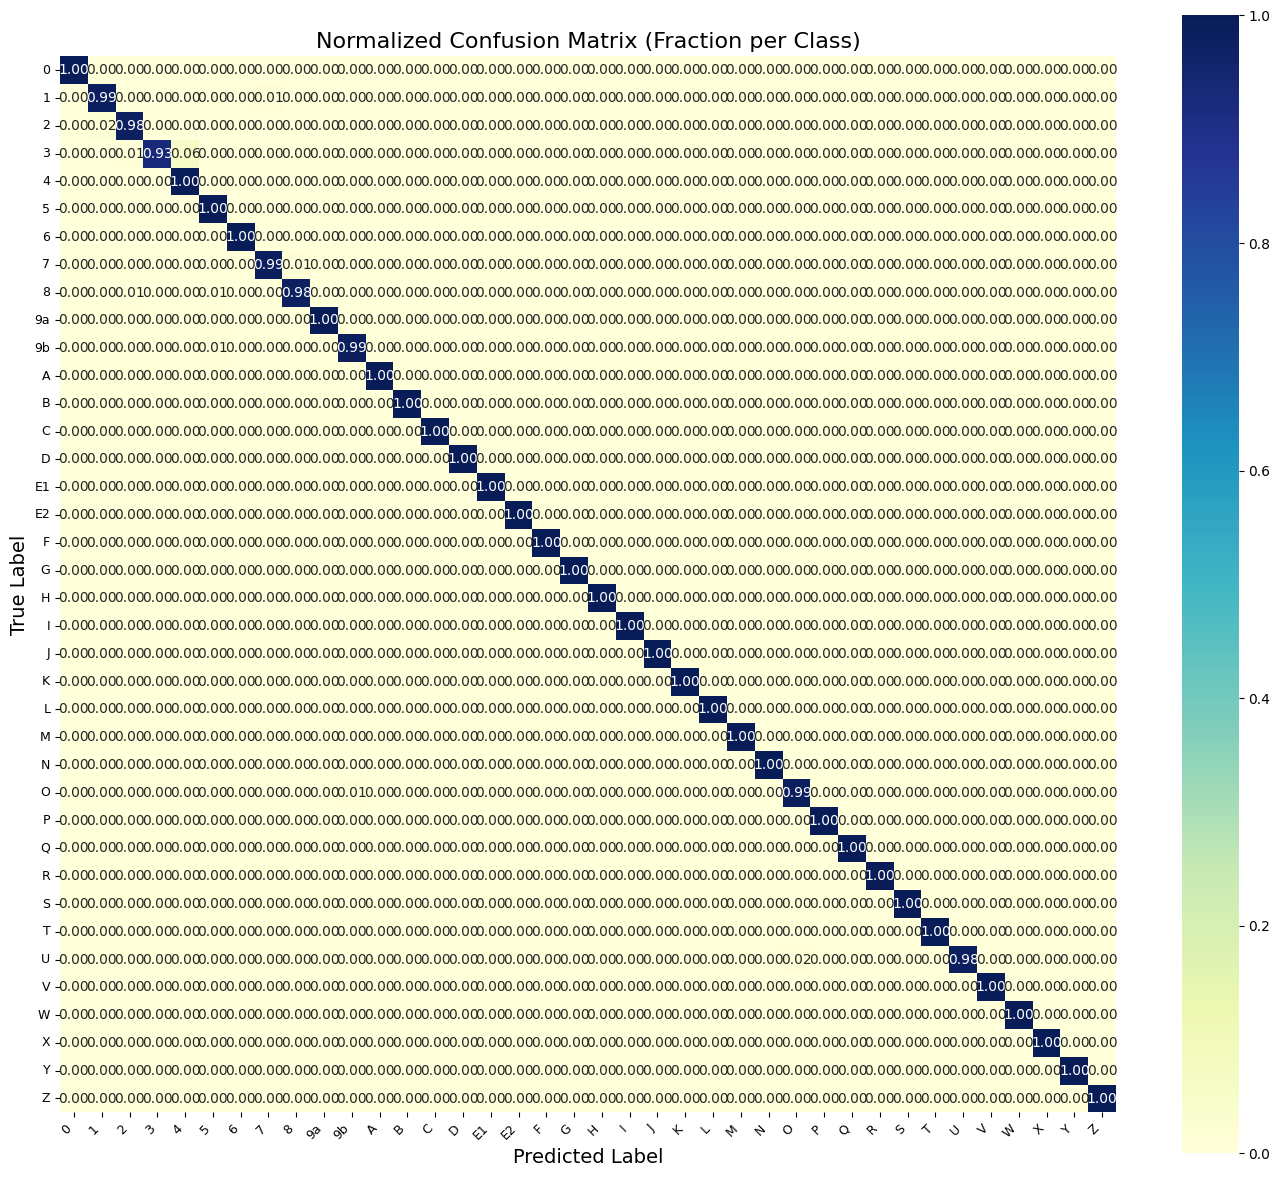

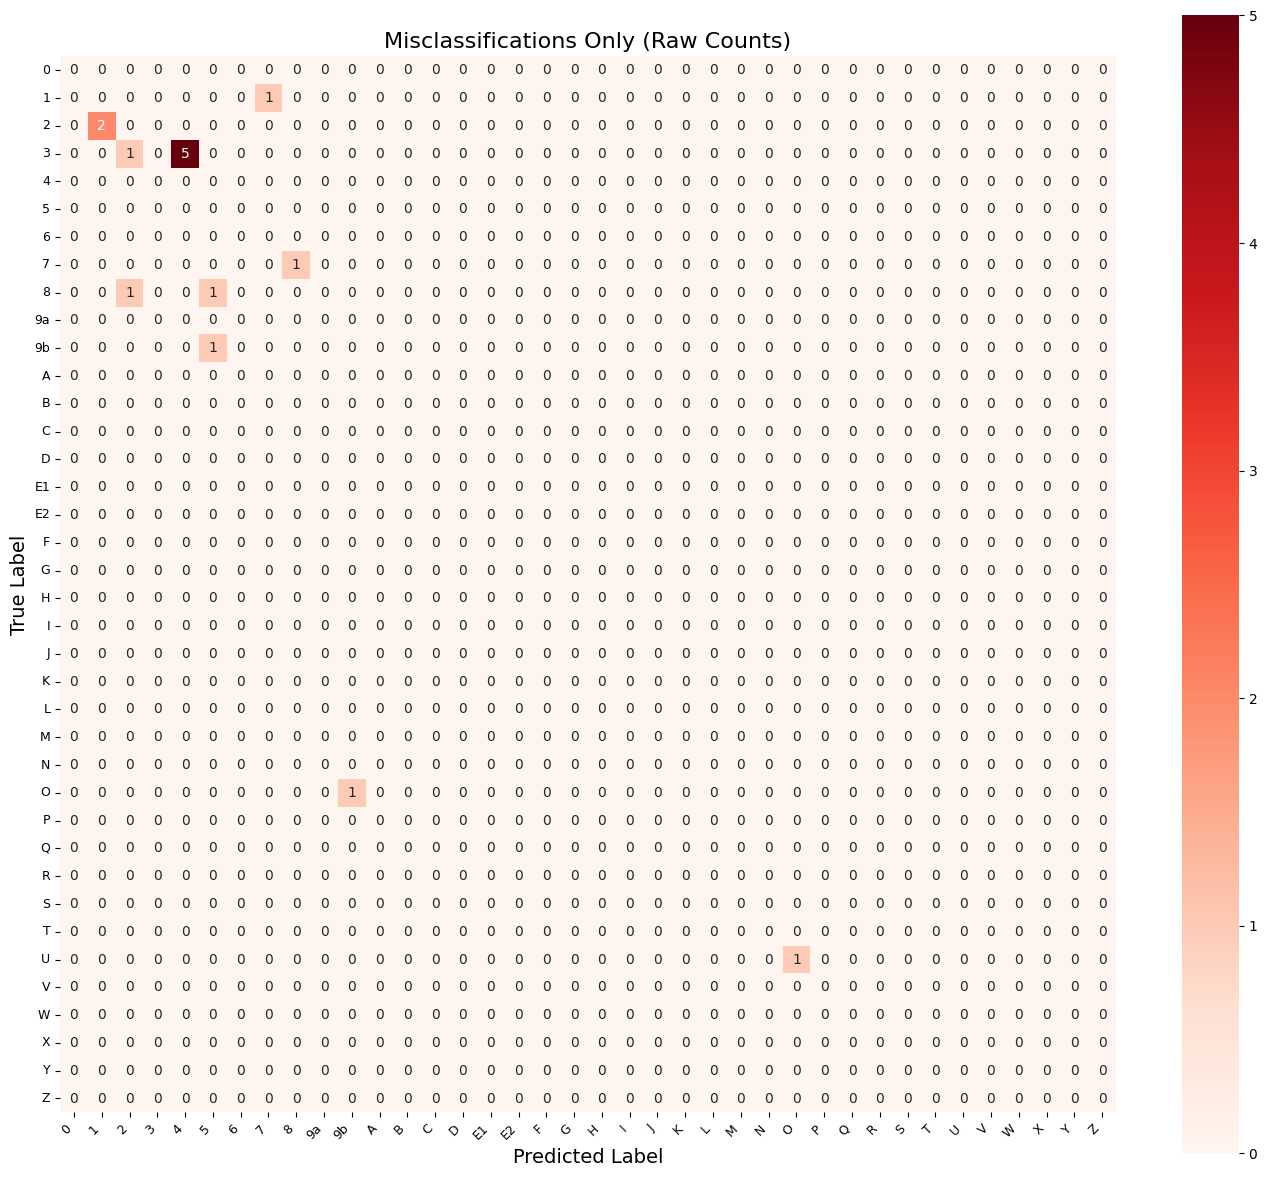


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        88
           1       0.97      0.99      0.98        78
           2       0.98      0.98      0.98        91
           3       1.00      0.93      0.96        86
           4       0.94      1.00      0.97        82
           5       0.98      1.00      0.99        80
           6       1.00      1.00      1.00        78
           7       0.99      0.99      0.99        85
           8       0.99      0.98      0.98        94
          9a       1.00      1.00      1.00        90
          9b       0.99      0.99      0.99        72
           A       1.00      1.00      1.00        73
           B       1.00      1.00      1.00        70
           C       1.00      1.00      1.00        58
           D       1.00      1.00      1.00        74
          E1       1.00      1.00      1.00        71
          E2       1.00      1.00      1.00        78
   

In [49]:
# === EVALUATION + CONFUSION MATRIX (Complete Updated Cell) ===
import tensorflow as tf
from tensorflow.keras.optimizers import AdamW
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# --- 1️⃣ Rebuild model architecture exactly as during training ---
print("Rebuilding EfficientNet model for evaluation...")
rebuilt_model = build_efficientnet_model(
    fine_tune=True,
    IMG_HEIGHT=224,
    IMG_WIDTH=224,
    unfreeze_layers=50
)

# --- 2️⃣ Load trained weights ---
weights_path = "/content/drive/MyDrive/model_checkpoints/EfficientNet_Stage2/final.weights.h5"
rebuilt_model.load_weights(weights_path)
print(f"✅ Weights loaded successfully from {weights_path}")

# --- 3️⃣ Compile model ---
rebuilt_model.compile(
    optimizer=AdamW(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.TopKCategoricalAccuracy(k=3, name="top_3_accuracy"),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name="top_5_accuracy"),
    ],
)
print("✅ Model compiled and ready!\n")

# --- 4️⃣ Evaluate on validation and test sets ---
print("Evaluating on validation set...")
val_results = rebuilt_model.evaluate(validation_generator, verbose=1)
print(f"\nValidation Accuracy: {val_results[1]*100:.2f}%")

print("\nEvaluating on test set...")
test_results = rebuilt_model.evaluate(test_generator, verbose=1)
print(f"\nTest Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]*100:.2f}%")
print(f"Top-3 Accuracy: {test_results[2]*100:.2f}%")
print(f"Top-5 Accuracy: {test_results[3]*100:.2f}%")

# --- 5️⃣ Confusion Matrix + Classification Report ---
print("\nGenerating confusion matrix...")

test_generator.reset()
predictions = rebuilt_model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# --- Plot 1: Normalized Confusion Matrix ---
plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix_norm,
            annot=True,
            fmt=".2f",
            cmap="YlGnBu",
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=True,
            square=True)
plt.title("Normalized Confusion Matrix (Fraction per Class)", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

# --- Plot 2: Misclassifications Only ---
errors = conf_matrix.copy()
np.fill_diagonal(errors, 0)

plt.figure(figsize=(14, 12))
sns.heatmap(errors,
            annot=True,
            fmt="d",
            cmap="Reds",
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=True,
            square=True)
plt.title("Misclassifications Only (Raw Counts)", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

# --- 6️⃣ Print Classification Report ---
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names, zero_division=0))

print("\n✅ Evaluation complete! Confusion matrices and report generated successfully.")


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_3024']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


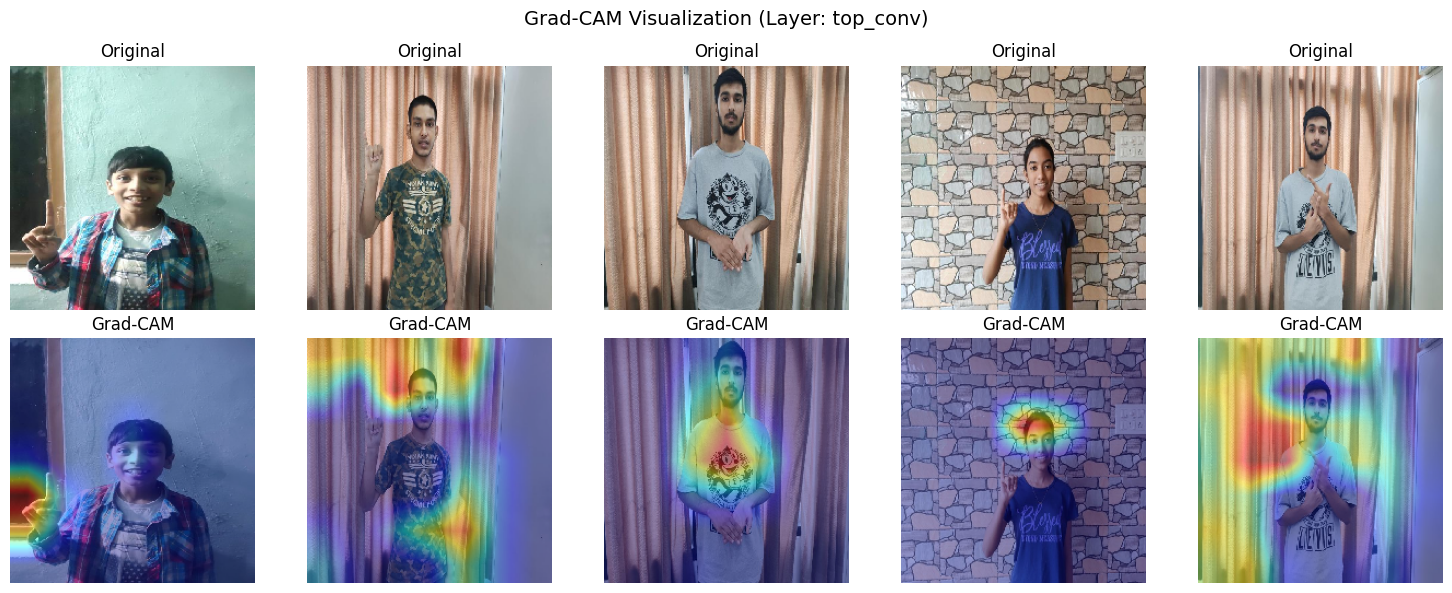

Computing per-class accuracy...
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 466ms/step


/tmp/ipython-input-650560774.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=per_class_acc, palette="viridis")


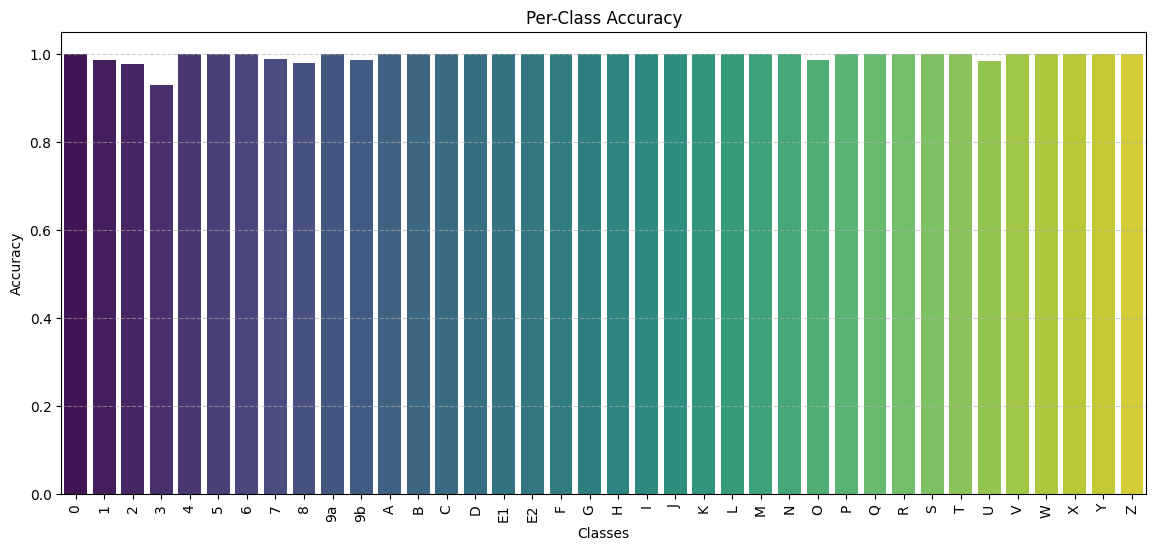

Generating and exporting classification report...
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 468ms/step
✅ Classification report saved in 'reports/classification_report.csv' and .tex


In [51]:
# === VISUALIZATION & REPORT CELL ===
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import cv2
import os

# ✅ 1️⃣ GRAD-CAM VISUALIZER ---------------------------------------------------
def get_gradcam_heatmap(model, img_array, layer_name):
    """Generate Grad-CAM heatmap for a given image and model layer."""
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Convert the heatmap tensor to a NumPy array before NumPy operations
    heatmap = heatmap.numpy()

    # Ensure heatmap is not all zeros before division
    if np.max(heatmap) == 0:
        return heatmap # Return the all-zero heatmap if no activation

    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def display_gradcam(model, generator, class_names, layer_name="top_conv", num_images=5):
    """Display Grad-CAM overlays for random test images."""
    os.makedirs("gradcam_outputs", exist_ok=True)
    # Ensure generator is reset for consistent sampling if needed, although random choice avoids this
    # generator.reset()
    sample_indices = np.random.choice(len(generator.filenames), num_images, replace=False)
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(sample_indices):
        img_path = os.path.join(generator.directory, generator.filenames[idx])
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

        # Ensure the model is available and compiled before calling get_gradcam_heatmap
        # This assumes 'rebuilt_model' is defined and compiled in a preceding cell

        heatmap = get_gradcam_heatmap(model, img_array, layer_name)

        # Ensure heatmap is a numpy array before using cv2.resize
        if heatmap is not None:
            heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
            heatmap = np.uint8(255 * heatmap)
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

            # Ensure the original image is in uint8 format for cv2.addWeighted
            original_img_cv2 = cv2.cvtColor(np.array(img).astype('uint8'), cv2.COLOR_RGB2BGR)
            superimposed_img = cv2.addWeighted(original_img_cv2, 0.6, heatmap, 0.4, 0)
            superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB) # Convert back to RGB for matplotlib

            plt.subplot(2, num_images, i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title("Original")
            plt.subplot(2, num_images, i + 1 + num_images)
            plt.imshow(superimposed_img)
            plt.axis("off")
            plt.title("Grad-CAM")
        else:
             plt.subplot(2, num_images, i + 1)
             plt.imshow(img)
             plt.axis("off")
             plt.title("Original")
             plt.subplot(2, num_images, i + 1 + num_images)
             plt.text(0.5, 0.5, "Heatmap Failed", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
             plt.axis("off")
             plt.title("Grad-CAM")


    plt.suptitle("Grad-CAM Visualization (Layer: {})".format(layer_name), fontsize=14)
    plt.tight_layout()
    plt.show()

# ✅ 2️⃣ PER-CLASS ACCURACY CHART ----------------------------------------------
def plot_per_class_accuracy(model, generator, class_names):
    print("Computing per-class accuracy...")
    generator.reset()
    # Ensure the model is available before prediction
    predictions = model.predict(generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    true_labels = generator.classes
    conf_mat = confusion_matrix(true_labels, predicted_classes)
    # Handle potential division by zero if a class has no samples (shouldn't happen with current split)
    with np.errstate(divide='ignore', invalid='ignore'):
        per_class_acc = np.nan_to_num(conf_mat.diagonal() / conf_mat.sum(axis=1))


    plt.figure(figsize=(14, 6))
    sns.barplot(x=class_names, y=per_class_acc, palette="viridis")
    plt.xticks(rotation=90)
    plt.ylim(0, 1.05)
    plt.title("Per-Class Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Classes")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

# ✅ 3️⃣ CLASSIFICATION REPORT EXPORT ------------------------------------------
def export_classification_report(model, generator, class_names, save_dir="reports"):
    print("Generating and exporting classification report...")
    os.makedirs(save_dir, exist_ok=True)
    generator.reset()
    # Ensure the model is available before prediction
    predictions = model.predict(generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    true_labels = generator.classes
    # Use zero_division parameter to handle classes with no true samples
    report_dict = classification_report(true_labels, predicted_classes, target_names=class_names, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report_dict).transpose()
    report_df.to_csv(os.path.join(save_dir, "classification_report.csv"), index=True)

    # Optional LaTeX export
    try:
        with open(os.path.join(save_dir, "classification_report.tex"), "w") as f:
             # Use float_format for consistent decimal places, and disable escape for underscores etc.
            f.write(report_df.to_latex(float_format="%.3f", escape=False))
        print(f"✅ Classification report saved in '{save_dir}/classification_report.csv' and .tex")
    except ImportError:
        print("⚠️ pandas.to_latex requires 'tabulate' or 'jinja2'. LaTeX report not generated.")
        print(f"✅ Classification report saved in '{save_dir}/classification_report.csv'")


# === RUN ALL VISUALIZATIONS ===
# Ensure 'rebuilt_model' and 'test_generator' are available from preceding cells
if 'rebuilt_model' in locals() and 'test_generator' in locals():
    class_names = list(test_generator.class_indices.keys())

    # Grad-CAM visualization (adjust layer name if needed)
    # Make sure the layer name exists in your model summary
    try:
        display_gradcam(rebuilt_model, test_generator, class_names, layer_name="top_conv", num_images=5)
    except ValueError as e:
        print(f"⚠️ Could not generate Grad-CAM: {e}. Ensure the layer name 'top_conv' exists in the model.")
        rebuilt_model.summary() # Print summary to help user find correct layer name

    # Per-class accuracy
    plot_per_class_accuracy(rebuilt_model, test_generator, class_names)

    # Export classification report
    export_classification_report(rebuilt_model, test_generator, class_names)
else:
    print("⚠️ Please ensure 'rebuilt_model' and 'test_generator' are defined and available by running preceding cells.")
    print("   'rebuilt_model' is typically created and loaded in the evaluation cell.")
    print("   'test_generator' is created in the data loading/preprocessing cells.")